### Analyzing firefigther calls 

If you are interested in the project, please, either fork it and submit a pull request, or contact us via Twitter or email.

_Mikhail Sirenko ([@mikhailsirenko](https://twitter.com/mikhailsirenko)), Trivik Verma ([@TrivikV](https://twitter.com/TrivikV)) and Igor Nikolic ([@ComplexEvo](https://twitter.com/ComplexEvo))_

#### Introduction

The New Year's Eve period in the Netherlands involves many fireworks, fire damage, and increasing violence directed at first responders. There is an active societal debate about whether consumer fireworks should be banned. In order to support this debate, we have analyzed the data from the national emergency network called __P2000__, which is publicly available. We are focusing on __firefighters__ and will not consider police and medical services. Data sources scraped and downloaded from two websites [p2000-online.net](http://p2000-online.net/) and [www.112-nederland.nl](www.112-nederland.nl).

The main goals are:
* first, visualize the data in an insightful way, 
* second, try to analyze the connection between firefighter calls and fireworks, 
* and finally, attempt an estimation of the damage.

The project outline is straightforward:<br>
<br> a). we load the data and make sure that it is correctly geographically allocated
<br> b). select the period for a more elaborate analysis
<br> c). categorize calls by the corresponding message and visualize them

#### a). Load the data and check coordinates

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')
import contextily as ctx

from src.data.prepare_data import prepare_gdf, select_ny, extract_categories

Load the data

The data set is table where the rows are the calls and the columns represent calls features. In total each call has 33 features. However, in this study we will focus only a couple of those. For instance:

* _pmeTimeStamp_ - is a __time__ when the call was registered in the system,
* _pmeStrippedMessage_ - the slightly preprocessed __message__ of the call,
* _pmeLatitude_ and _pmeLongitude_ - __latitude__ and __longitude__ of the calls.

Note that for Den Haag _pmeGeoAccuracy_ can be different = __S__, __H__ or __W__. Some calls initially have only the street names whereas others exact house numbers. For example, Torenstraat and Stationsplein, 67. This information is stored in _pmeMessage_ as a text.   

In [3]:
data = pd.read_csv("../data/processed/den_haag_ff_calls.csv")
print(f"Total number of records collected : {data.shape[0]}")

# Format the pmeTimeStamp column
data["pmeTimeStamp"] = pd.to_datetime(data["pmeTimeStamp"])

# Convert the data to appropriate format
gdf = prepare_gdf(data)

Total number of records collected : 25374
Total number of records collected with assigned coordinates : 25374


Select the calls that were made from the city area

In [4]:
%%time
# Load municipal border
polygon = gpd.read_file('../data/processed/den_haag_borders.json', driver="GeoJSON")

mask = gdf.within(polygon["geometry"].iloc[0])
print(f"Total number of records collected with assigned coordinates : {gdf.shape[0]}")
print(f"Number of records within Den Haag municipal border : {gdf.loc[mask].shape[0]}")

# Select for future analysis only those that are within the municipal border
gdf = gdf.loc[mask]
df = data.loc[mask]

Total number of records collected with assigned coordinates : 25374
Number of records within Den Haag municipal border : 24756
Wall time: 14.3 s


/home/igor/.local/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/igor/.local/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


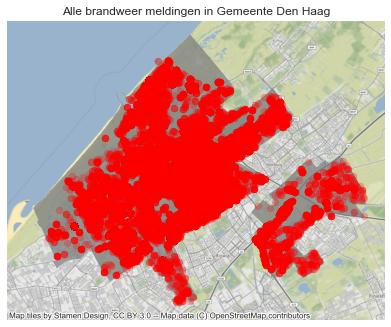

In [5]:
# Plot all firefighter calls
# Map
ax = polygon.to_crs(epsg=3857).plot(color='gray', alpha=.75)
gdf.to_crs(epsg=3857).plot(ax=ax, color='red', alpha=.25);
ctx.add_basemap(ax=ax)
plt.axis('off');
ax.set_title('Alle brandweer meldingen in Gemeente Den Haag');

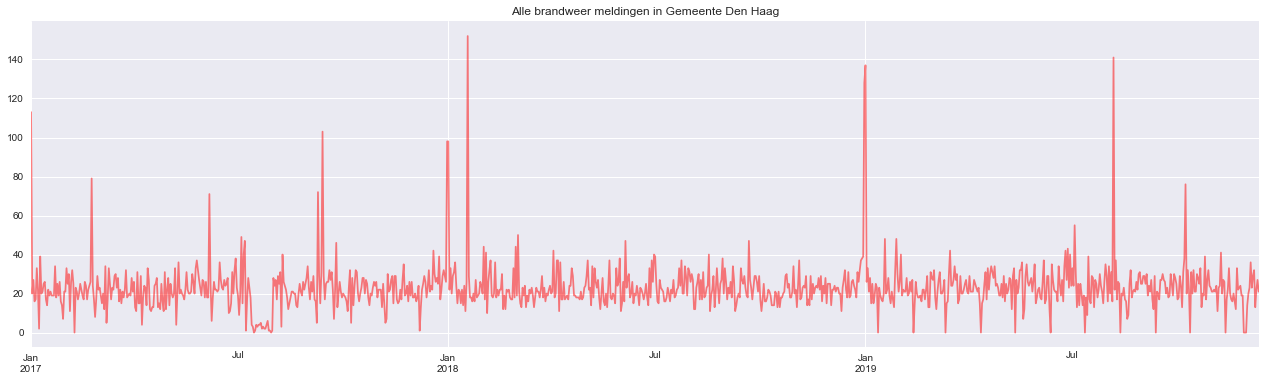

In [6]:
# Time series
ax = df.set_index('pmeTimeStamp').groupby(pd.Grouper(freq='D')).count()['pmeId'].plot(figsize=(22,6), color='red', alpha=.5)
ax.set_xlabel('')
ax.set_title('Alle brandweer meldingen in Gemeente Den Haag');

#### b). Select the period for a more extensive analysis

The number of firefigthers calls made from 2017-12-31 00:00:00 to 2018-01-02 00:00:00 : 196
The number of firefigthers calls made from 2018-12-31 00:00:00 to 2019-01-02 00:00:00 : 265


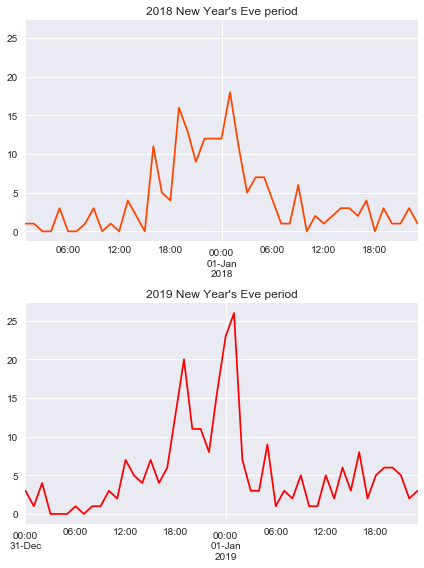

In [7]:
years = [2018, 2019]
rows = [0, 1]
colors = ['orangered', 'red']
fig, ax = plt.subplots(nrows=2, sharey=True, figsize=(6,8))

for row, year, color in zip(rows, years, colors):
    ny = select_ny(df, year=year, delta=1)
    ny.set_index('pmeTimeStamp').groupby(pd.Grouper(freq='H')).count()['pmeId'].plot(ax=ax[row], color=color)
    ax[row].set_xlabel('')
    ax[row].set_title(f"{year} New Year's Eve period")
fig.tight_layout()

The number of firefigthers calls made from 2017-12-31 00:00:00 to 2018-01-02 00:00:00 : 196
The number of firefigthers calls made from 2018-12-31 00:00:00 to 2019-01-02 00:00:00 : 265


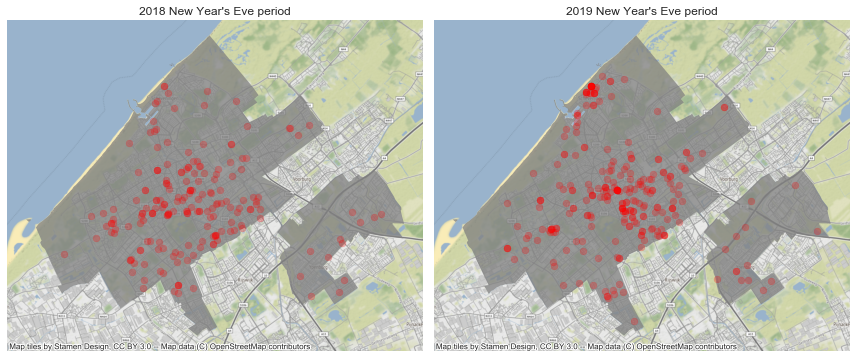

In [8]:
years = [2018, 2019]
cols = [0, 1]
fig, ax = plt.subplots(ncols=2, figsize=(12,8))

for col, year in zip(cols, years):
    ny = select_ny(gdf, year=year, delta=1)
    polygon.to_crs(epsg=3857).plot(color='gray', alpha=.75, figsize=(8,6), ax=ax[col])
    ny.to_crs(epsg=3857).plot(ax=ax[col], color='red', alpha=.25)
    ctx.add_basemap(ax=ax[col])
    ax[col].axis('off')
    ax[col].set_title(f"{year} New Year's Eve period")
fig.tight_layout()

#### c). Check the calls by type

In [9]:
# Specify the categories of interest
categories = ['Buitenbrand afval/rommel', 'Gebouwbrand woning', 'Buitenbrand container', 'Voertuigbrand']

The number of firefigthers calls made from 2017-12-31 00:00:00 to 2018-01-02 00:00:00 : 196
The number of firefigthers calls made from 2018-12-31 00:00:00 to 2019-01-02 00:00:00 : 265


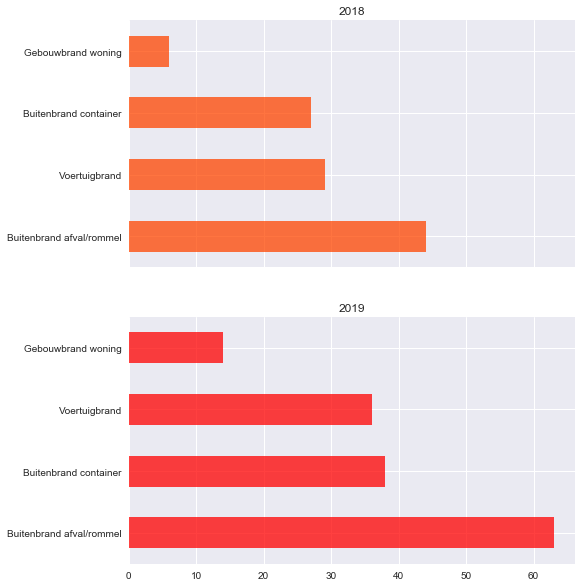

In [10]:
years = [2018, 2019]
rows = [0, 1]
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(8,10))
years = [2018, 2019]

for year, row, color in zip(years, rows, colors):
    cat = extract_categories(df, year, categories)
    cat['pmeCategory'].value_counts().plot.barh(color=color, alpha=.75, ax=ax[row])
    ax[row].set_title(year)

The number of firefigthers calls made from 2017-12-31 00:00:00 to 2018-01-02 00:00:00 : 196
The number of firefigthers calls made from 2018-12-31 00:00:00 to 2019-01-02 00:00:00 : 265


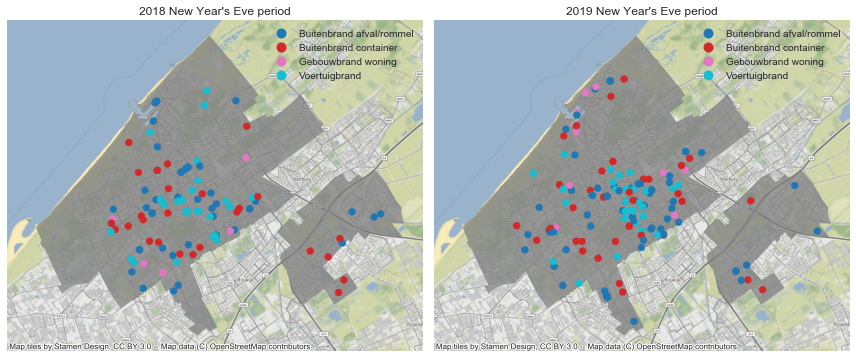

In [11]:
years = [2018, 2019]
cols = [0, 1]
fig, ax = plt.subplots(ncols=2, figsize=(12,8))

for col, year in zip(cols, years):
    cat = extract_categories(gdf, year, categories)
    polygon.to_crs(epsg=3857).plot(color='gray', alpha=.75, figsize=(8,6), ax=ax[col])
    cat.to_crs(epsg=3857).plot(ax=ax[col], column='pmeCategory', legend=True)
    ctx.add_basemap(ax=ax[col])
    ax[col].axis('off')
    ax[col].set_title(f"{year} New Year's Eve period")
fig.tight_layout()

Visualize the data with Kepler.gl. Note that Kepler.gl Python package works only with Jupyter Notebook view and doesn't support JupyterLab.

In [12]:
ny = select_ny(gdf, year=2019, delta=1)

The number of firefigthers calls made from 2018-12-31 00:00:00 to 2019-01-02 00:00:00 : 265


In [15]:
# Load kepler.gl with map data and config
from keplergl import KeplerGl
%run config.py
map_1 = KeplerGl(height=600, data={'data_1': ny}, config=config)
map_1

# # Save config
# with open('hex_config.py', 'w') as f:
#     f.write('config = {}'.format(map_1.config))

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': 'data_1', 'id': '5qzlns5xd', …

### References

1. P2000 netwerk meelezen. (n.d.). Retrieved from http://p2000-online.net/
2. SNOEI.NET (2020). 112 Nederland. Retrieved from https://www.112-nederland.nl/